In [1]:
%matplotlib inline

# import packages
import numpy as np
import time
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib import gridspec


In [2]:
# define plot properties
from cycler import cycler
import matplotlib.cm as cm

from matplotlib import rcParams
from matplotlib import rc
from mpl_toolkits.axes_grid1 import make_axes_locatable

def rgb(r,g,b):
    return (float(r)/256.,float(g)/256.,float(b)/256.)

cb2 = [rgb(31,120,180), rgb(255,127,0), rgb(51,160,44), rgb(227,26,28), \
       rgb(166,206,227), rgb(253,191,111), rgb(178,223,138), rgb(251,154,153)]

rcParams['figure.figsize'] = (9,7.5)
#rcParams['figure.dpi'] = 300

rcParams['lines.linewidth'] = 1

rcParams['axes.prop_cycle'] = cycler('color', cb2)
rcParams['axes.facecolor'] = 'white'
rcParams['axes.grid'] = False

rcParams['patch.facecolor'] = cb2[0]
rcParams['patch.edgecolor'] = 'white'

#rcParams['font.family'] = 'Bitstream Vera Sans' 
rcParams['font.size'] = 23
rcParams['font.weight'] = 300


> Load data.

In [ ]:
# load all the array
arr = np.load("../DES_DR1.npy")

# permute the data
rng = np.random.RandomState(seed=42)
pidx = rng.permutation(len(arr))
arr = arr[pidx]
    
# crop the image
arr = arr[:,32:96,32:96,:]

# scale data
arr = np.clip(np.arcsinh(0.01*arr)+0.4,0,5)/5

# further scale to make the color pop
arr[:,:,:,0] = arr[:,:,:,0] * 1.5
arr[:,:,:,1] = arr[:,:,:,1] * 1.2
arr[:,:,:,2] = arr[:,:,:,2] * 1.1
arr = np.clip(arr,0,1)


In [ ]:
# load a channel of an image
channel_choice = 2

# choose an image
image_choice = 0


> Histogram of individual channels.

In [ ]:
plt.hist(arr[:,:,:,0].ravel(), alpha=0.5, bins=100);
plt.hist(arr[:,:,:,1].ravel(), alpha=0.5, bins=100);
plt.hist(arr[:,:,:,2].ravel(), alpha=0.5, bins=100);

> Show images.

In [ ]:
plt.imshow(arr[image_choice,:,:,:])

In [ ]:
# restore results
import imageio

# choose a subset of images
X = arr[:64]

#-----------------------------------------------------------------------------
# plot the tiled results
n_samples = X.shape[0]
rows = int(np.sqrt(n_samples))
while n_samples % rows != 0:
    rows -= 1

nh, nw = rows, int(n_samples/rows)

h, w = X[0].shape[:2]
img = np.zeros((h*nh, w*nw, 3))

#-----------------------------------------------------------------------------
# loop over all images
for n, x in enumerate(X):
    j = int(n/nw)
    i = n%nw
    x_temp = np.copy(x)
    img[j*h:j*h+h, i*w:i*w+w, :] = x_temp

# save images
imageio.imwrite("Results.png", img)

In [ ]:
# save training set
arr = np.swapaxes(arr,3,1)
np.save("../training_set_des.npy", arr)


> Plot training loss.

(0.0001, 0.001)

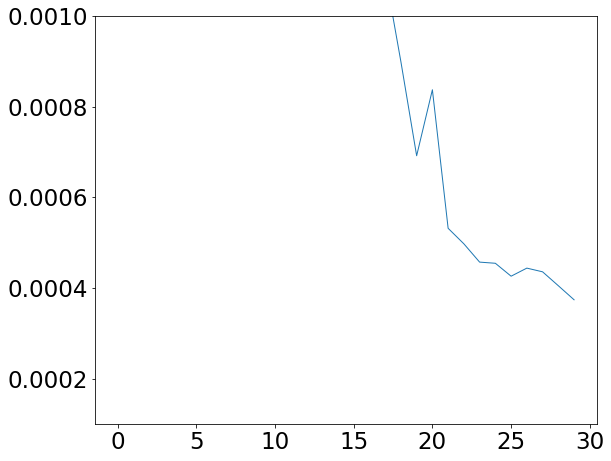

In [17]:
mse_err_array = []

for i in range(30):
    temp = np.load("../results_2D/results_2D_random_zdim=4_random_" \
                   + "batch_randomize_times1_epoch=" + str((i+1)*100-1) + ".npz")
    mse_err_array.append(temp["mse_err"])

plt.plot(mse_err_array)
plt.ylim([0.0001,0.001])

> Restore 2D networks and results.

In [ ]:
# restore results
temp = np.load("../results_2D.npz")
data_np = temp["data_np"]
plt.hist(np.log(data_np).flatten())

In [22]:
# restore results
import imageio

# restore results
temp = np.load("../results_2D_zdim=4_random_batch_cont_times1_epoch=2999.npz")
samples_np = temp["samples_np"][::10][:100,:]

temp = np.load("../results_2D_random_conditional.npz")
samples_np = temp["samples_np"][:100,:]

# swap channel axis
X = np.swapaxes(samples_np,3,1)
X = np.clip(X,0.1,1.)

#-----------------------------------------------------------------------------
# plot the tiled results
n_samples = X.shape[0]
rows = int(np.sqrt(n_samples))
while n_samples % rows != 0:
    rows -= 1

nh, nw = rows, int(n_samples/rows)

h, w = X[0].shape[:2]
img = np.zeros((h*nh, w*nw, 3))

#-----------------------------------------------------------------------------
# loop over all images
for n, x in enumerate(X):
    j = int(n/nw)
    i = n%nw
    x_temp = np.copy(x)
    img[j*h:j*h+h, i*w:i*w+w, :] = x_temp

# save images
imageio.imwrite("../Results_2D_mock.png", img)


#==============================================================================
# restore results
import imageio

# restore results
temp = np.load("../results_2D_zdim=4_random_batch_cont_times1_epoch=2999.npz")
data_np = temp["data_np"][::10,:][:100,:]

# swap channel axis
X = np.swapaxes(data_np,3,1)
X = np.clip(X,0.1,1.)

#-----------------------------------------------------------------------------
# plot the tiled results
n_samples = X.shape[0]
rows = int(np.sqrt(n_samples))

while n_samples % rows != 0:
    rows -= 1

nh, nw = rows, int(n_samples/rows)

h, w = X[0].shape[:2]
img = np.zeros((h*nh, w*nw, 3))

#-----------------------------------------------------------------------------
# loop over all images
for n, x in enumerate(X):
    j = int(n/nw)
    i = n%nw
    x_temp = np.copy(x)
    img[j*h:j*h+h, i*w:i*w+w, :] = x_temp

# save images
imageio.imwrite("../Results_2D_real.png", img)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


> Restore 3D networks and results.

In [ ]:
# restore results
import imageio

# restore results
temp = np.load("../results_3D.npz")
samples_np = temp["samples_np"][0,0,:,:,:]
data_np = temp["data_np"][0,0,:,:,:]

# set range
X = np.clip(samples_np,5.,10.)

#-----------------------------------------------------------------------------
# plot the tiled results
n_samples = X.shape[0]
rows = int(np.sqrt(n_samples))
while n_samples % rows != 0:
    rows -= 1

nh, nw = rows, int(n_samples/rows)

h, w = X[0].shape[:2]
img = np.zeros((h*nh, w*nw))

#-----------------------------------------------------------------------------
# loop over all images
for n, x in enumerate(X):
    j = int(n/nw)
    i = n%nw
    x_temp = np.copy(x)
    img[j*h:j*h+h, i*w:i*w+w] = x_temp

# save images
imageio.imwrite("../Results_3D_mock.png", img)


#==============================================================================
# restore results
import imageio

# restore results
temp = np.load("../results_3D.npz")
samples_np = temp["samples_np"][0,0,:,:,:]
data_np = temp["data_np"][0,0,:,:,:]

# set range
X = np.clip(data_np,5.,10.)

#-----------------------------------------------------------------------------
# plot the tiled results
n_samples = X.shape[0]
rows = int(np.sqrt(n_samples))

while n_samples % rows != 0:
    rows -= 1

nh, nw = rows, int(n_samples/rows)

h, w = X[0].shape[:2]
img = np.zeros((h*nh, w*nw))

#-----------------------------------------------------------------------------
# loop over all images
for n, x in enumerate(X):
    j = int(n/nw)
    i = n%nw
    x_temp = np.copy(x)
    img[j*h:j*h+h, i*w:i*w+w] = x_temp

# save images
imageio.imwrite("../Results_3D_real.png", img)


In [ ]:
plt.imshow(samples_np[10,0,slice,:,:], vmin=5, vmax=10, cmap="Greys")


In [ ]:
print(samples_np.shape)
print(data_np.shape)
plt.hist(samples_np.flatten(), bins=100);
plt.hist(data_np.flatten(), bins=100, alpha=0.5);

## Curate Zeldovich Approximation data.

In [ ]:
# restore data
temp = np.load("../Zeldovich_Approximation.npz")
sim_z0 = temp["sim_z0"]
sim_z0 = sim_z0.reshape(sim_z0.shape[0]*sim_z0.shape[1],1,sim_z0.shape[2],sim_z0.shape[3])
sim_z0 = sim_z0[:,:,::2,::2][:,:,2:-2,2:-2]
print(sim_z0.shape)
sim_z50 = temp["sim_z50"]


# Investigate NN structure.

In [4]:
# import package
import torch.nn as nn
import torch

#----------------------------------------------------------------------------------------
# define network
class View(nn.Module):
    def __init__(self, shape):
        super(View, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)

class DeeperConvImplicitModel(torch.nn.Module):
    def __init__(self, z_dim, init_weight_factor = 1.):
        super(DeeperConvImplicitModel, self).__init__()
        self.z_dim = z_dim
        self.init_weight_factor = init_weight_factor

        layers = [View((-1,z_dim,1,1))]

        for i in range(4):

            for j in range(5):

                if i == 0 and j == 0:
                    layers.append(torch.nn.ConvTranspose2d(z_dim, 512, 4, stride=1, padding=0))
                    layers.append(torch.nn.BatchNorm2d(512, momentum=0.001, affine=False))
                    layers.append(torch.nn.LeakyReLU(0.2, inplace=True))
                else:
                    layers.append(torch.nn.Conv2d(512, 512, 5, stride=1, padding=2))
                    layers.append(torch.nn.BatchNorm2d(512, momentum=0.001, affine=False))
                    layers.append(torch.nn.LeakyReLU(0.2, inplace=True))

            if i < 3:
                layers.append(torch.nn.Upsample(scale_factor=2, mode='bilinear', align_corners = False))
            else:
                layers.append(torch.nn.Conv2d(512, 3, 5, stride=1, padding=2))
                layers.append(torch.nn.Sigmoid())

        self.model = torch.nn.Sequential(*layers)
        self.add_module("model", self.model)

    def forward(self, z):
        return self.model(z)
    
#----------------------------------------------------------------------------------------
class IMLE():
    def __init__(self, z_dim):
        self.z_dim = z_dim
        self.model = DeeperConvImplicitModel(z_dim)
        
    
#========================================================================================
# initate model
z_dim = 64
batch_size = 2        
imle = IMLE(z_dim)

# load previous model
state_dict = torch.load("../checkpoint_single_channel_init_later.pth.tar",\
                        map_location=torch.device('cpu'))
imle.model.load_state_dict(state_dict)

# test output
z = torch.randn(batch_size, z_dim)
print(imle(z).shape)




ModuleNotFoundError: No module named 'imle'

## Inspect data.


In [ ]:
train_data = np.load("../training_set_des.npy")[::100,0:1,:,:]
print(train_data.shape)

plt.hist(train_data.flatten(), bins=[0])